# Problem Definition

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

This dataset is used to predict whether a patient is **likely to get stroke** based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.
* id: Unique identifier
* gender: "Male" or "Female" or "Other"
* age: age of the patient
* hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* ever_married: "No" or "Yes"
* work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* Residence_type: "Rural" or "Urban"
* avg_glucose_level: average glucose level in blood
* bmi: body mass index
* smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
* stroke: 1 if the patient had a stroke or 0 if not

<"Unknown" in the smoking_status means that the information is unavailable for this patient>



# Import Libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, log_loss, recall_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.impute import SimpleImputer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.cluster import KElbowVisualizer

# Date Gathering

* Read the dataset

In [2]:
PATH = "D:\\Learn\\Uni\\ML\\CapstoneProject\\data\\healthcare-dataset-stroke-data.csv"

df = pd.read_csv(PATH)
df.head() 

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data Preparation

* Get basic information from the dataset

-> Let's start by standardizing all column name

In [3]:
df.columns = df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5104 entries, 0 to 5103
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5104 non-null   int64  
 1   gender             5104 non-null   object 
 2   age                5104 non-null   float64
 3   hypertension       5104 non-null   int64  
 4   heart_disease      5104 non-null   int64  
 5   ever_married       5104 non-null   object 
 6   work_type          5104 non-null   object 
 7   residence_type     5104 non-null   object 
 8   avg_glucose_level  5104 non-null   float64
 9   bmi                4903 non-null   float64
 10  smoking_status     5104 non-null   object 
 11  stroke             5104 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 478.6+ KB


* We have 5110 instances with the 11 features and 1 target variable.
* We have both  numerical and categorical variables (8 numerical, 4 categorical).
* The most important column is our target variable "stroke".
* Target variable is coded as 1 for positive cases and 0 for negative cases.
* "Hypertension" and "heart disease" columns are coded like "stroke" column.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5104.0,36496.701215,21161.207853,67.00,17737.5000,36898.500,54625.75,72940.00
age,5104.0,43.213754,22.621771,0.08,25.0000,45.000,61.00,82.00
hypertension,5104.0,0.097375,0.296496,0.00,0.0000,0.000,0.00,1.00
heart_disease,5104.0,0.054075,0.226188,0.00,0.0000,0.000,0.00,1.00
avg_glucose_level,5104.0,106.137580,45.282155,55.12,77.2375,91.865,114.09,271.74
bmi,4903.0,28.891862,7.858238,10.30,23.5000,28.000,33.10,97.60
stroke,5104.0,0.048393,0.214617,0.00,0.0000,0.000,0.00,1.00


* The `describe` function give us an overview of the values of each columns. Above we can see some basic descriptive statistics for all numeric columns. By default, the function only describe columns that have Dtype is primative.

In [6]:
df.describe(include=object).T

,count,unique,top,freq
gender,5104,3,Female,2992
ever_married,5104,2,Yes,3348
work_type,5104,5,Private,2920
residence_type,5104,2,Urban,2594
smoking_status,5104,4,never smoked,1892


* With the Object Dtype , we cant have some attributes like mean or std... Instead of that, we have `unique` represents for how many lables , `fre`,..

In [7]:
df.duplicated().value_counts()

False    5104
Name: count, dtype: int64

* There is no duplicated value in the dataset

In [8]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

* The `bmi` columns has 201 null values. We will not delete these instacnes from the dataset cause the dataset is too small. So we will fill it before applying model.

## Data Cleaning

* Firstly, We will drop `id` column cause it is useless for predicting `stroke`

In [9]:
df.drop('id', axis=1, inplace=True) # axis = 1 means we are working on columns, 0 for rows
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

* Before deeping into the analysis it would be beneficial to examine the `correlation` among variables using heatmap

<Axes: >

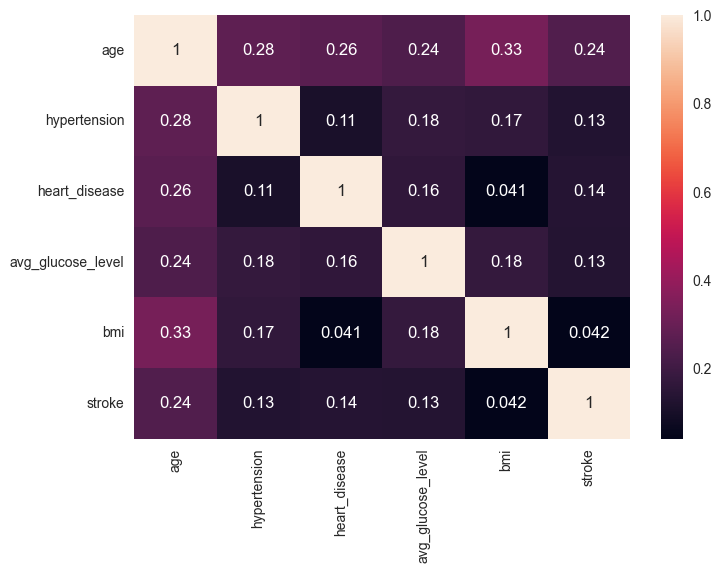

In [10]:
sns.heatmap(df.corr(numeric_only=True), annot=True) # Using `seaborn` lib

* Let's split our features into two part, `numerical` and `categorical`, for easing our further examination.

In [11]:
numerical= df.drop(['stroke'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')


Categorical Columns: Index(['gender', 'ever_married', 'work_type', 'residence_type',
       'smoking_status'],
      dtype='object')


### The Examination of Target Variable


In [12]:
df['stroke'].describe()

count    5104.000000
mean        0.048393
std         0.214617
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: stroke, dtype: float64

stroke
0    4857
1     247
Name: count, dtype: int64

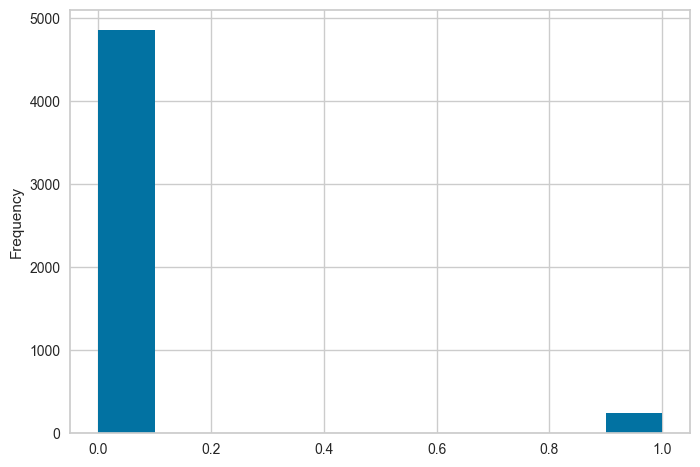

In [13]:
df['stroke'].plot(kind = 'hist')
df['stroke'].value_counts()

* `stroke` column is coded as 1 for cases(has a stroke) and 0 for negative cases(does not have a stroke)
* Approximately 95% of our target variable is `No Stroke` (4861)
* 5% of the instances of our target varibale is `Stroke` (249)

### Numerical Features

In [14]:
df[numerical].head()

,age,hypertension,heart_disease,avg_glucose_level,bmi
0,67.0,0,1,228.69,36.6
1,61.0,0,0,202.21,NaN
2,80.0,0,1,105.92,32.5
3,49.0,0,0,171.23,34.4
4,79.0,1,0,174.12,24.0


In [15]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5104.0,43.213754,22.621771,0.08,25.0000,45.000,61.00,82.00
hypertension,5104.0,0.097375,0.296496,0.00,0.0000,0.000,0.00,1.00
heart_disease,5104.0,0.054075,0.226188,0.00,0.0000,0.000,0.00,1.00
avg_glucose_level,5104.0,106.137580,45.282155,55.12,77.2375,91.865,114.09,271.74
bmi,4903.0,28.891862,7.858238,10.30,23.5000,28.000,33.10,97.60


<Axes: ylabel='Count'>

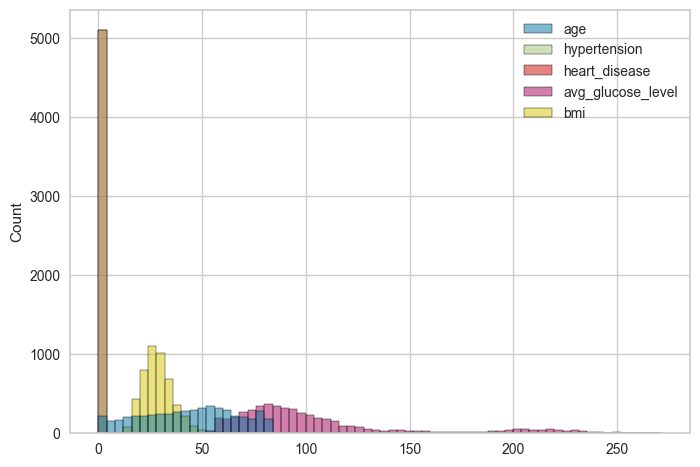

In [16]:
sns.histplot(df[numerical])

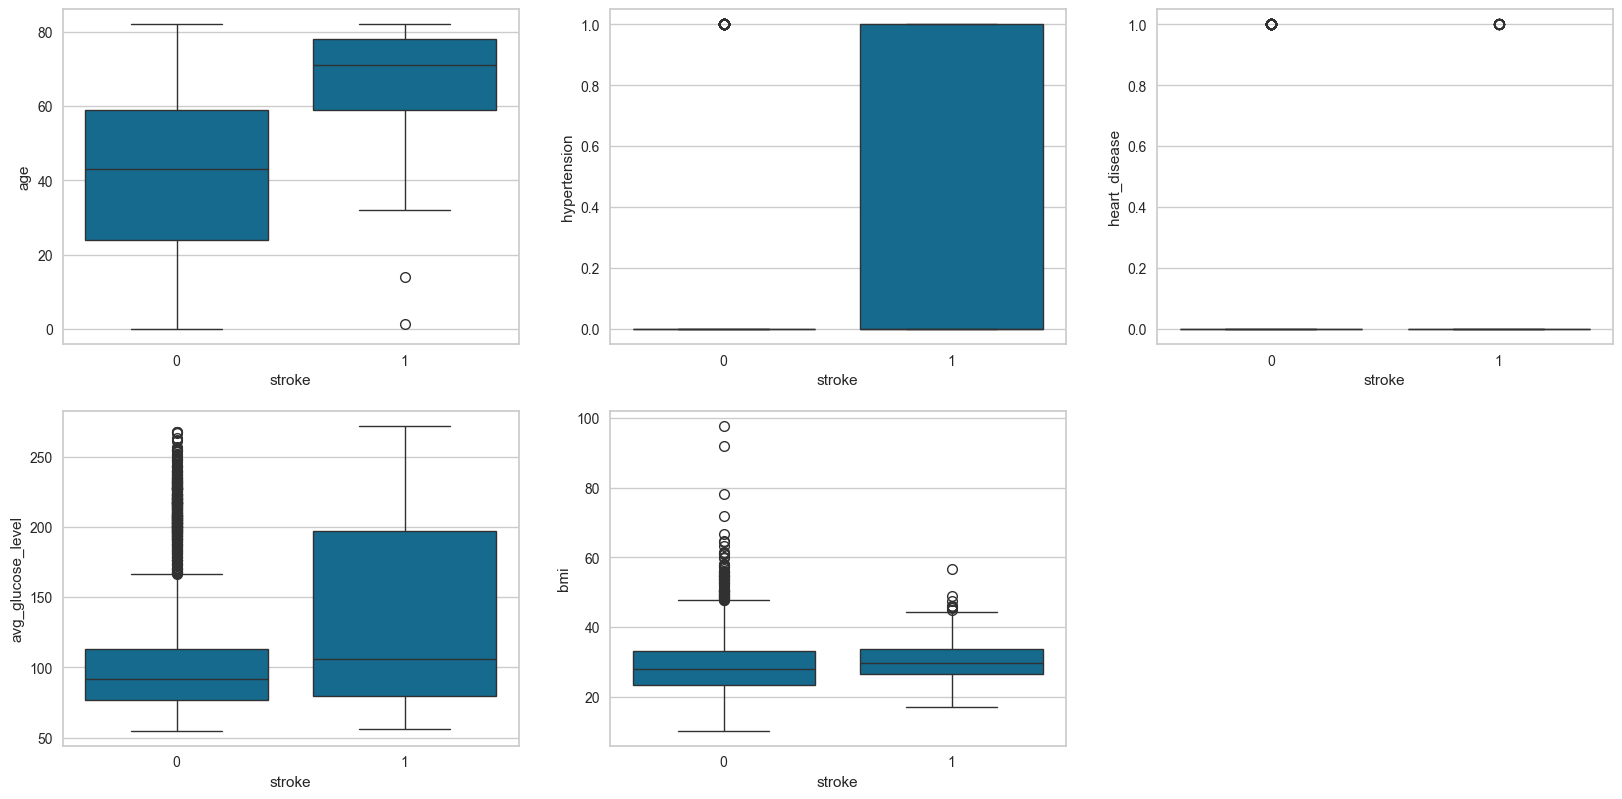

In [17]:
index = 0
plt.figure(figsize=(20,20))
for feature in numerical:
    if feature != "stroke":
        index += 1
        plt.subplot(4,3,index) # Create plt grid with 4 rows and 3 columns and the position of the current subplot
        sns.boxplot(x='stroke',y=feature,data=df)

#### Examining the distribution of each attribute

In [18]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_vals = df[numerical].skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

heart_disease        3.944498
hypertension         2.716953
avg_glucose_level    1.572592
bmi                  1.055406
dtype: float64

<Axes: ylabel='Count'>

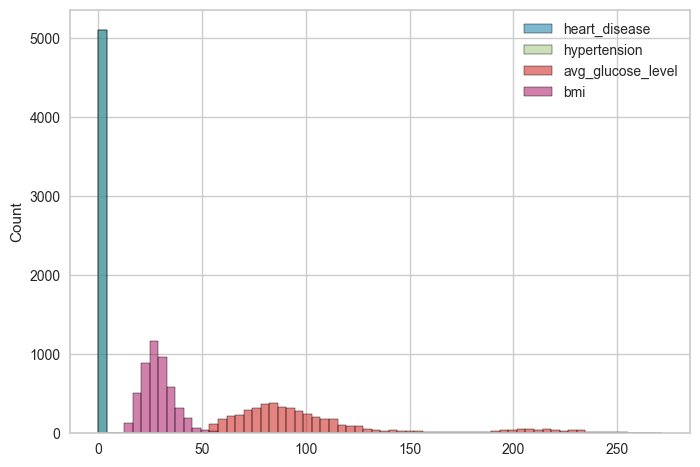

In [19]:
sns.histplot(df[skew_cols.index])

<Axes: xlabel='bmi', ylabel='Count'>

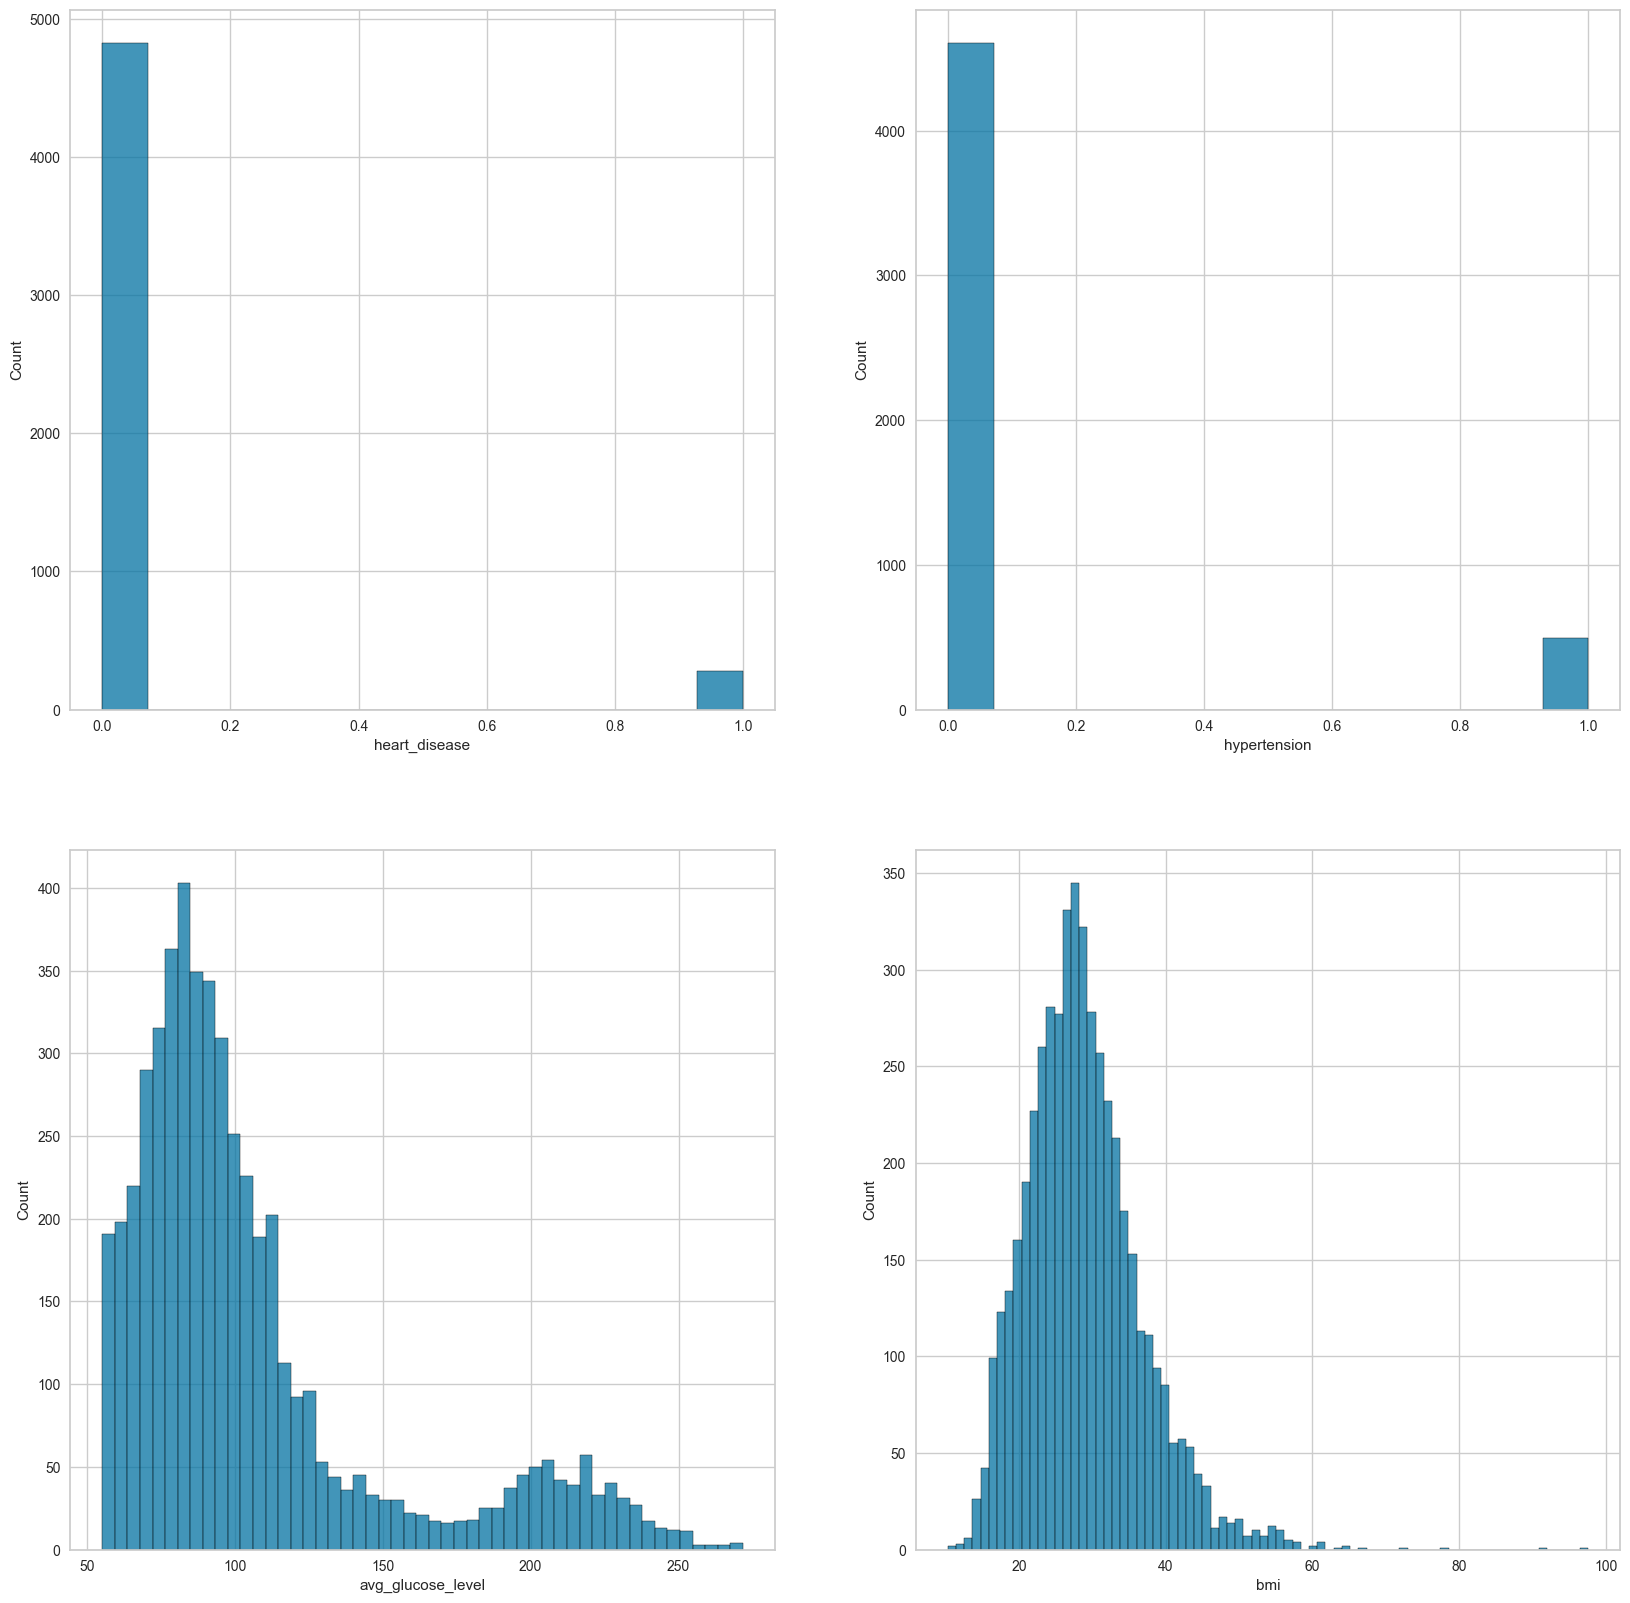

In [20]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.histplot(df['heart_disease'])

plt.subplot(2,2,2)
sns.histplot(df['hypertension'])

plt.subplot(2,2,3)
sns.histplot(df['avg_glucose_level'])

plt.subplot(2,2,4)
sns.histplot(df['bmi'])

* Some features have skewness. Let's try to handle with their skewness by `np.log` and `PowerTransformer`.

#### Handling with Skewness

In [21]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models.
skew_vals = df[numerical].skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols = skew_cols.drop(['heart_disease', 'hypertension'])
skew_cols

avg_glucose_level    1.572592
bmi                  1.055406
dtype: float64

* **Dealing with `np.log`**

avg_glucose_level    0.889491
bmi                  0.032726
dtype: float64



<Axes: ylabel='Count'>

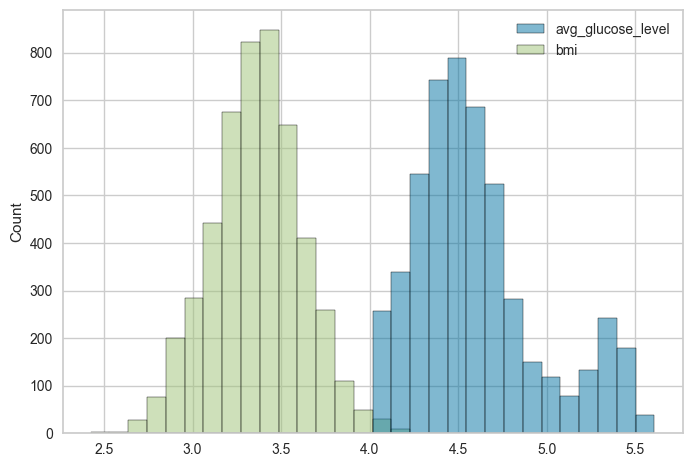

In [22]:
df_try = df.copy()
df_try = df[skew_cols.index].copy()
for col in skew_cols.index.values:
    df_try[col] = df_try[col].apply(np.log1p) # applying np.log to deal with skewness
print(df_try[skew_cols.index].skew())
print()

sns.histplot(df_try[skew_cols.index])


* After applying `np.log`, we can see the skewness of `bmi` is below our thresh-hold skewness limit. But skewness of `avg_glucose_level` is still high

* **With Power Transformer**

avg_glucose_level    0.084609
bmi                 -0.000752
dtype: float64



<Axes: ylabel='Count'>

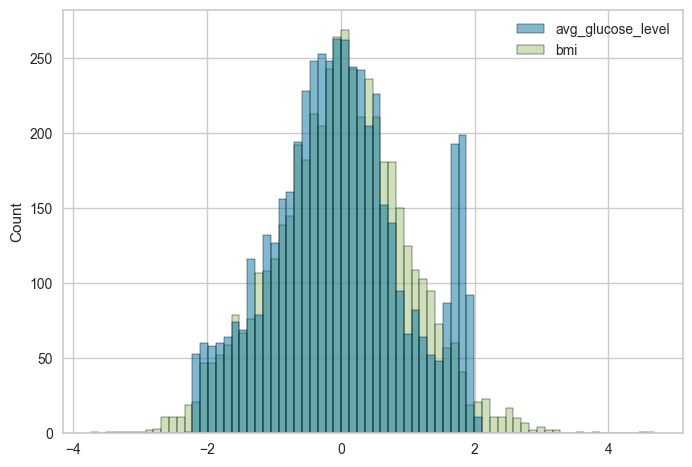

In [23]:
df_trans = df[skew_cols.index].copy()
pt = PowerTransformer(method='yeo-johnson')
trans= pt.fit_transform(df_trans)
df_trans = pd.DataFrame(trans, columns =skew_cols.index )
print(df_trans.skew())
print()

sns.histplot(df_trans)

* Finally, The skewness is very low, approximately 0

* Replacing 2 above columns 

In [24]:
df_trans.columns

Index(['avg_glucose_level', 'bmi'], dtype='object')

In [25]:
df.drop(['avg_glucose_level', 'bmi'], axis=1, inplace=True)
df.shape

(5104, 9)

In [26]:
df = pd.concat([df, df_trans], axis=1)
df.shape

(5104, 11)

In [27]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'smoking_status', 'stroke',
       'avg_glucose_level', 'bmi'],
      dtype='object')

In [28]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. 
                  # Overall below abs(1) seems acceptable for the linear models.
skew_vals = df[numerical].skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

heart_disease    3.944498
hypertension     2.716953
dtype: float64

<Axes: >

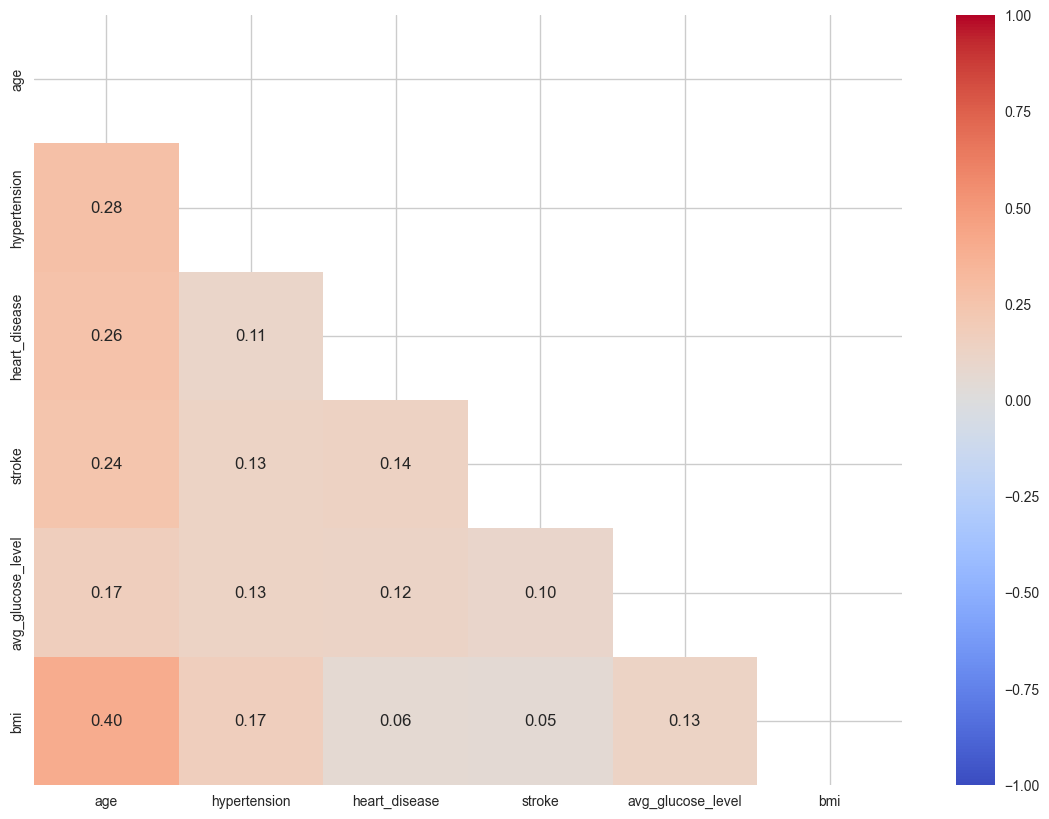

In [29]:
numerical= df.select_dtypes('number').columns

matrix = np.triu(df[numerical].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax)

### Overview for each column

* I will create my own function for viewing easier

In [30]:
# To view summary information about the column

def first_looking(col):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))

In [31]:
first_looking("age")

column name    :  age
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  104
age
78.00    102
57.00     95
52.00     89
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: count, Length: 104, dtype: int64


In [32]:
first_looking("hypertension")

column name    :  hypertension
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
hypertension
0    4607
1     497
Name: count, dtype: int64


In [33]:
first_looking("heart_disease")

column name    :  heart_disease
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
heart_disease
0    4828
1     276
Name: count, dtype: int64


In [34]:
first_looking("avg_glucose_level")

column name    :  avg_glucose_level
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3977
avg_glucose_level
 0.036049    6
-0.040021    5
-0.876290    5
-0.373675    5
-0.333457    5
            ..
 0.544524    1
 0.053497    1
 0.092043    1
-1.294973    1
 1.395237    1
Name: count, Length: 3977, dtype: int64


In [35]:
first_looking("bmi")

column name    :  bmi
--------------------------------
per_of_nulls   :  % 3.94
num_of_nulls   :  201
num_of_uniques :  418
bmi
 NaN         201
 0.108174     41
 0.068498     38
-0.164592     37
-0.039397     37
            ... 
-3.331111      1
 1.416112      1
 2.480079      1
 4.688352      1
-2.363267      1
Name: count, Length: 419, dtype: int64


### Categorical Features

In [36]:
df[categorical].head()

,gender,ever_married,work_type,residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


In [37]:
df[categorical].describe().T

,count,unique,top,freq
gender,5104,3,Female,2992
ever_married,5104,2,Yes,3348
work_type,5104,5,Private,2920
residence_type,5104,2,Urban,2594
smoking_status,5104,4,never smoked,1892


In [38]:
first_looking("gender")

column name    :  gender
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  3
gender
Female    2992
Male      2111
Other        1
Name: count, dtype: int64


* We can see that there is only 1 value of `Other`, so it can be entered incorrectly. Let's drop it

In [39]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)

In [40]:
first_looking("gender")

column name    :  gender
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
gender
Female    2992
Male      2111
Name: count, dtype: int64


In [41]:
first_looking("ever_married")

column name    :  ever_married
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
ever_married
Yes    3348
No     1755
Name: count, dtype: int64


In [42]:
first_looking("work_type")

column name    :  work_type
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5
work_type
Private          2919
Self-employed     819
children          687
Govt_job          656
Never_worked       22
Name: count, dtype: int64


In [43]:
print(df.groupby('work_type')['stroke'].mean().sort_values())

work_type
Never_worked     0.000000
children         0.002911
Govt_job         0.050305
Private          0.050360
Self-employed    0.079365
Name: stroke, dtype: float64


In [44]:
first_looking("residence_type")

column name    :  residence_type
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
residence_type
Urban    2594
Rural    2509
Name: count, dtype: int64


In [45]:
first_looking("smoking_status")

column name    :  smoking_status
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
smoking_status
never smoked       1892
Unknown            1541
formerly smoked     882
smokes              788
Name: count, dtype: int64


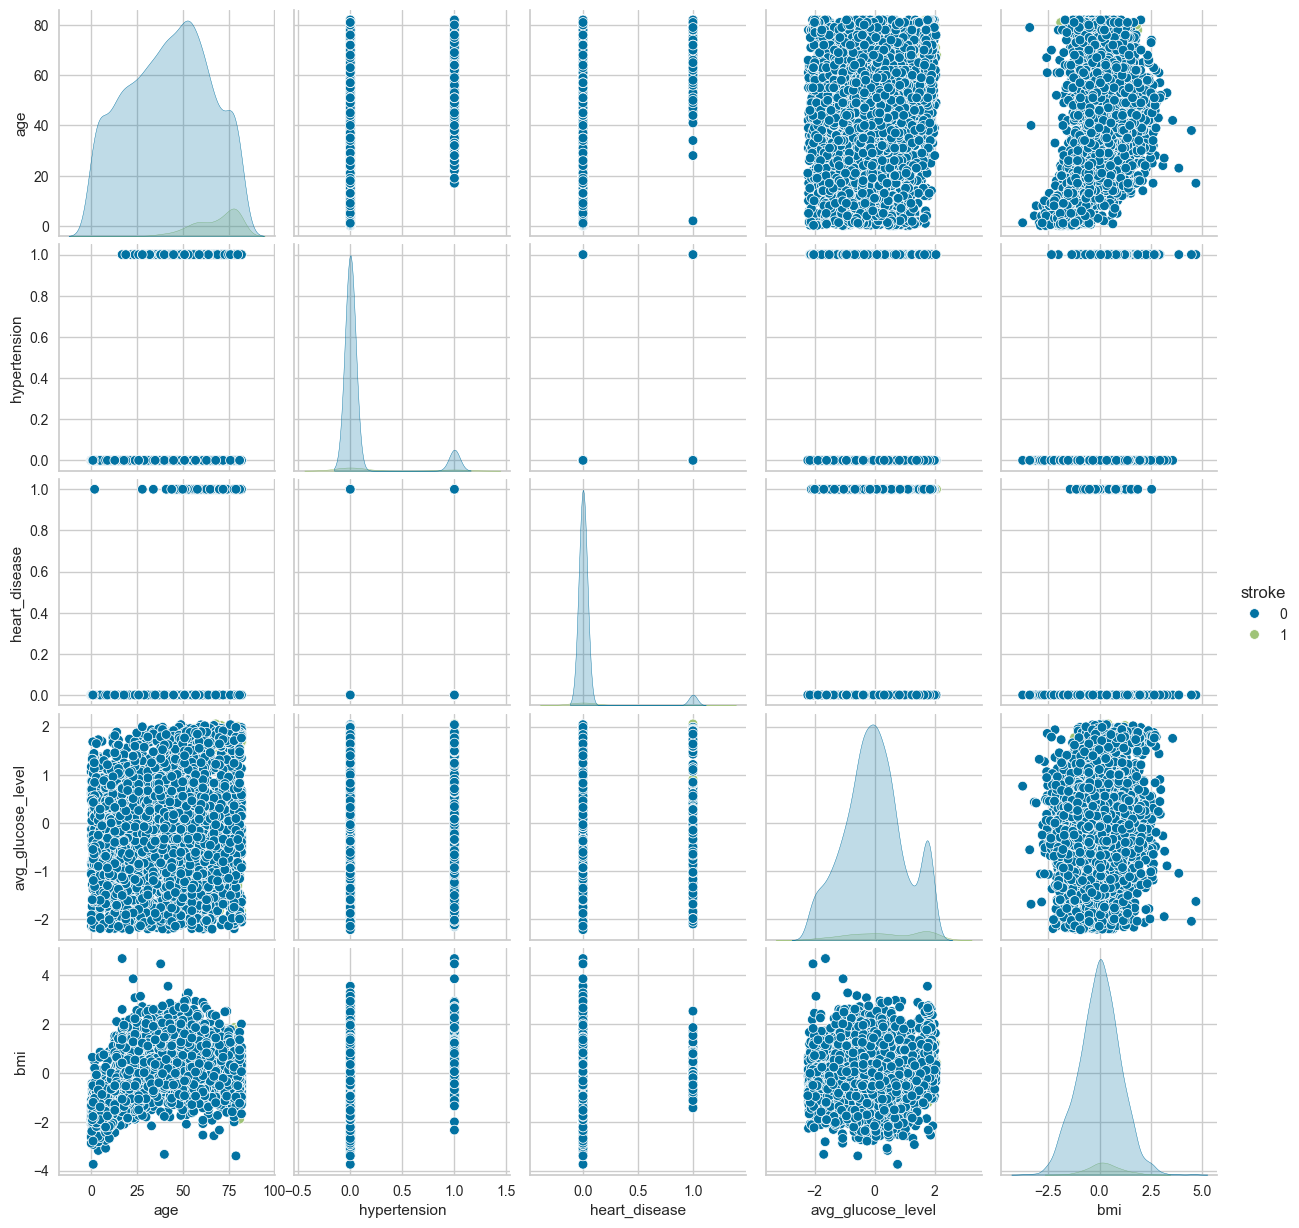

In [46]:
sns.pairplot(df, hue="stroke")

<Axes: xlabel='avg_glucose_level', ylabel='age'>

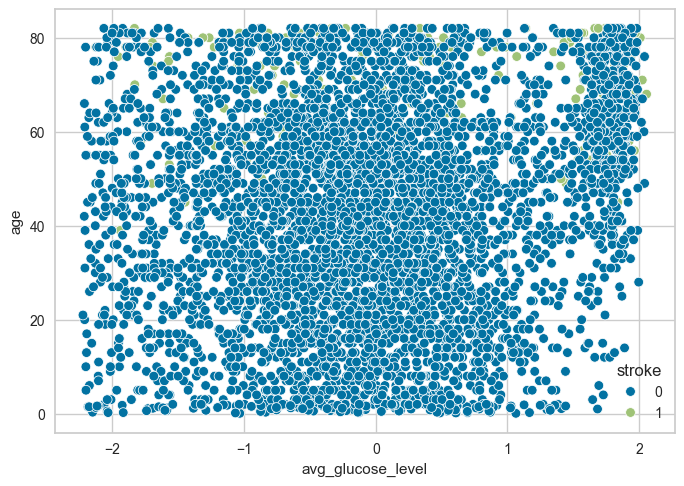

In [47]:
sns.scatterplot(x = 'avg_glucose_level', y = 'age', hue = 'stroke', data = df)

<Axes: xlabel='bmi', ylabel='age'>

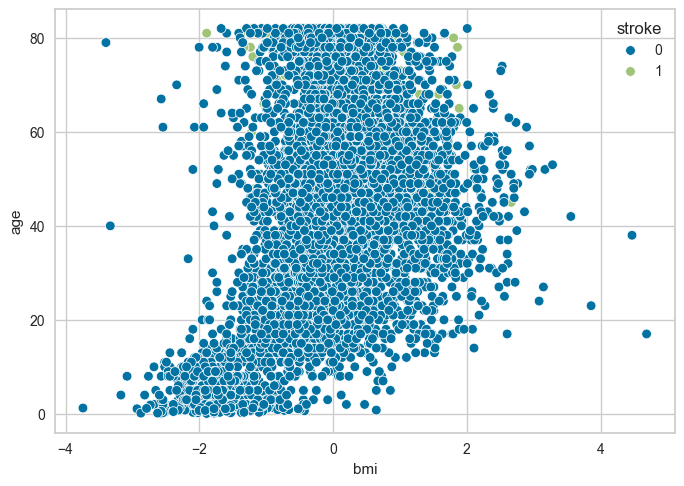

In [48]:
sns.scatterplot(x = 'bmi', y = 'age', hue = 'stroke', data = df)

<Axes: xlabel='avg_glucose_level', ylabel='bmi'>

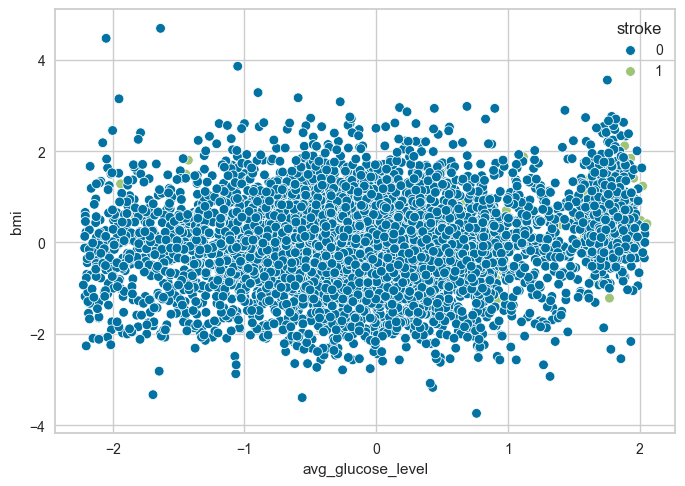

In [49]:
sns.scatterplot(x = 'avg_glucose_level', y = 'bmi', hue = 'stroke', data = df)

# Dummy Operations

In [50]:
df = pd.get_dummies(df, columns=['gender', 'ever_married',
       'work_type', 'residence_type', 'smoking_status',], drop_first=True)

In [51]:
df.head()

,age,hypertension,heart_disease,stroke,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,1.862436,1.025498,True,True,False,True,False,False,True,True,False,False
1,61.0,0,0,1,1.700512,NaN,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,1,0.394991,0.577499,True,True,False,True,False,False,False,False,True,False
3,49.0,0,0,1,1.445072,0.791806,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,1,1.472875,-0.567210,False,True,False,False,True,False,False,False,True,False


In [52]:
df.shape

(5103, 16)

<Axes: >

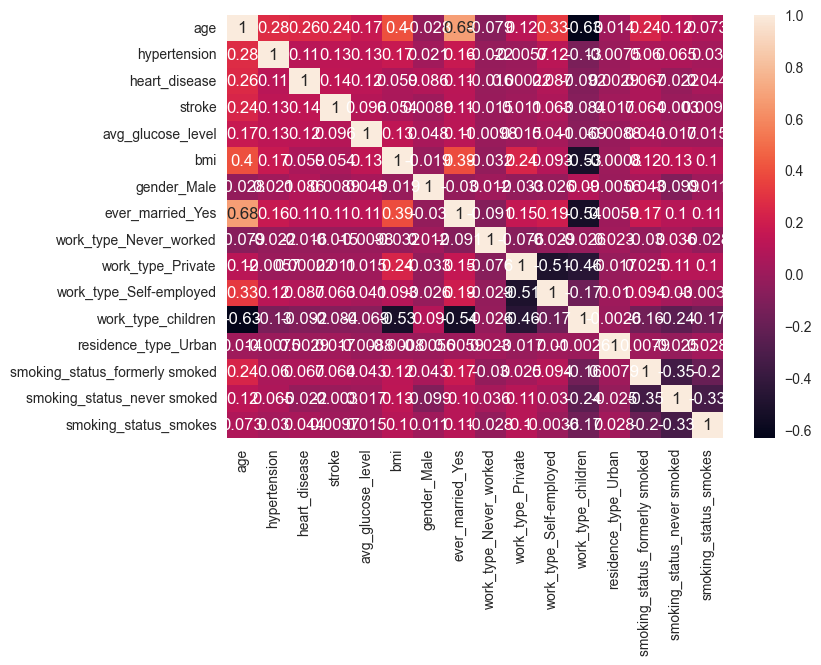

In [53]:
sns.heatmap(df.corr(), annot=True)

# Data Preprocessing

In [54]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median") 

df['bmi'] = imputer.fit_transform(df['bmi'].values.reshape(-1,1))[:,0]


* Fill all missing values in `bmi` column with `median`

In [55]:
X = df.drop('stroke', axis=1)
y = df['stroke']

* Train / Test and Split

In [56]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

* Oversampling the dataset cause the imbalance of the data will affect significiantly to score

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

* Scaling

In [58]:
scaler = MinMaxScaler()
scaler

MinMaxScaler()

In [59]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Implement KNN and Evaluate

In [60]:
knn_model = KNeighborsClassifier(1) 

In [61]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [62]:
y_pred = knn_model.predict(X_test)

In [63]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9221002059025395
[[1309  167]
 [  60 1378]]
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1476
           1       0.89      0.96      0.92      1438

    accuracy                           0.92      2914
   macro avg       0.92      0.92      0.92      2914
weighted avg       0.92      0.92      0.92      2914



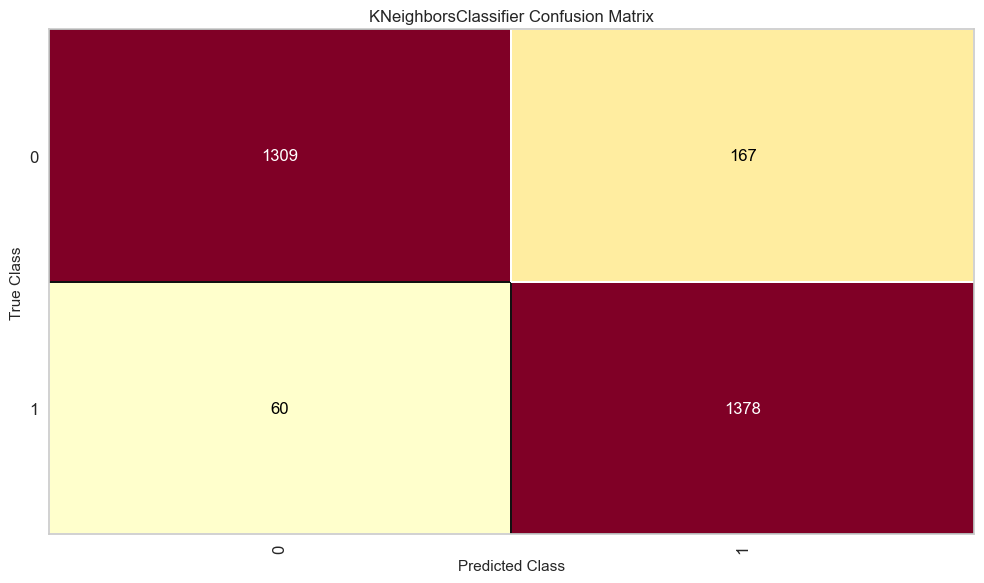

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [64]:
plt.figure(figsize=(10, 6))
cm = ConfusionMatrix(knn_model)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Elbow Method for Choosing Reasonable K Values

In [65]:
test_error_rate = []

for k in range(1, 40):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    y_pred = knn_model.predict(X_test)
    test_error_rate.append(1 - accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Error Rate')

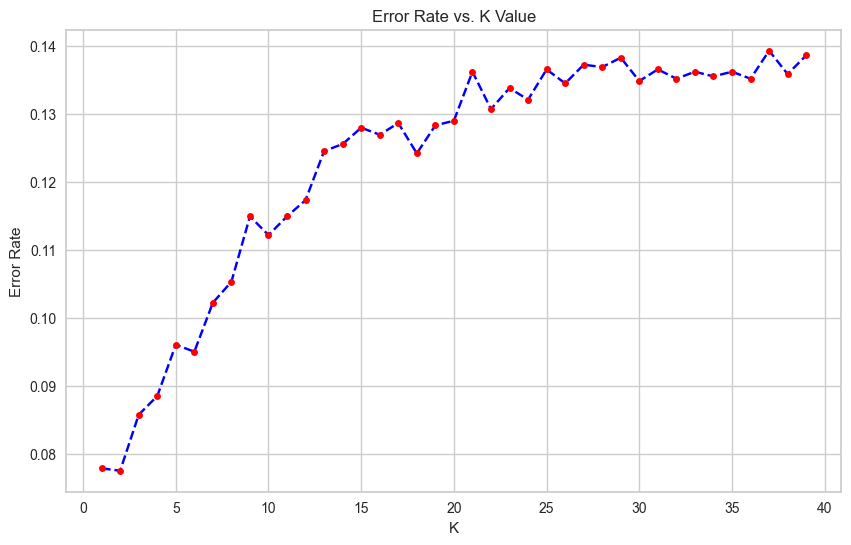

In [66]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),test_error_rate,color='blue', linestyle='dashed', marker='.',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

* Scores by Various K Values

In [67]:
# FIRST A QUICK COMPARISON TO OUR DEFAULT VALUE K=5
from sklearn.metrics import f1_score, precision_score


model = KNeighborsClassifier()

model.fit(X_train,y_train)
y_pred = model.predict(X_test)



cm = confusion_matrix(y_test, model.predict(X_test))

print("Confusion Matrix: \n", cm)
print("Model testing accuracy:", ((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))*100, "%", sep=' ')

print(f'Precision Score: {precision_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'Recall Score: {recall_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, model.predict(X_test))*100:.2f}%')
print()

Confusion Matrix: 
 [[1266  210]
 [  70 1368]]
Model testing accuracy: 90.39121482498285 %
Precision Score: 86.69%
Recall Score: 95.13%
F1 Score: 90.72%



In [68]:
# WITH K=1
model = KNeighborsClassifier(n_neighbors=1)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('WITH K=1')
cm = confusion_matrix(y_test, model.predict(X_test))

print("Confusion Matrix: \n", cm)
print("Model testing accuracy:", ((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))*100, "%", sep=' ')

print(f'Precision Score: {precision_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'Recall Score: {recall_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, model.predict(X_test))*100:.2f}%')
print()

WITH K=1
Confusion Matrix: 
 [[1309  167]
 [  60 1378]]
Model testing accuracy: 92.21002059025395 %
Precision Score: 89.19%
Recall Score: 95.83%
F1 Score: 92.39%



In [69]:
# WITH K=2
model = KNeighborsClassifier(n_neighbors=2)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('WITH K=2')
cm = confusion_matrix(y_test, model.predict(X_test))

print("Confusion Matrix: \n", cm)
print("Model testing accuracy:", ((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))*100, "%", sep=' ')

print(f'Precision Score: {precision_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'Recall Score: {recall_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, model.predict(X_test))*100:.2f}%')
print()

WITH K=2
Confusion Matrix: 
 [[1353  123]
 [ 103 1335]]
Model testing accuracy: 92.24433768016472 %
Precision Score: 91.56%
Recall Score: 92.84%
F1 Score: 92.20%



In [70]:
# WITH K=3
model = KNeighborsClassifier(n_neighbors=3)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)


print('WITH K=3')
cm = confusion_matrix(y_test, model.predict(X_test))

print("Confusion Matrix: \n", cm)
print("Model testing accuracy:", ((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))*100, "%", sep=' ')

print(f'Precision Score: {precision_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'Recall Score: {recall_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, model.predict(X_test))*100:.2f}%')
print()

WITH K=3
Confusion Matrix: 
 [[1282  194]
 [  56 1382]]
Model testing accuracy: 91.42072752230611 %
Precision Score: 87.69%
Recall Score: 96.11%
F1 Score: 91.71%



In [71]:
# WITH K=4
model = KNeighborsClassifier(n_neighbors=4)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('WITH K=4')
cm = confusion_matrix(y_test, model.predict(X_test))

print("Confusion Matrix: \n", cm)
print("Model testing accuracy:", ((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))*100, "%", sep=' ')

print(f'Precision Score: {precision_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'Recall Score: {recall_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, model.predict(X_test))*100:.2f}%')
print()

WITH K=4
Confusion Matrix: 
 [[1318  158]
 [ 100 1338]]
Model testing accuracy: 91.1461908030199 %
Precision Score: 89.44%
Recall Score: 93.05%
F1 Score: 91.21%



* Cross Validate For Optimal K Value

In [72]:
model = KNeighborsClassifier(n_neighbors=1)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision','recall',
                                                                   'f1'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1
1,0.016175,0.056614,0.923529,0.894022,0.961988,0.926761
2,0.017741,0.056510,0.938235,0.909836,0.973684,0.940678
3,0.016230,0.066109,0.927941,0.897019,0.967836,0.931083
4,0.017149,0.058016,0.913235,0.907781,0.921053,0.914369
5,0.017127,0.056556,0.925000,0.890080,0.970760,0.928671
6,0.017842,0.057649,0.904412,0.865435,0.959064,0.909847
7,0.019261,0.057190,0.933824,0.909091,0.964912,0.936170
8,0.017253,0.057987,0.914706,0.887978,0.950292,0.918079
9,0.017154,0.056422,0.916053,0.890110,0.950147,0.919149
10,0.016144,0.056515,0.910162,0.870370,0.964809,0.915160


In [73]:
df_scores.mean()[2:]

test_accuracy     0.920710
test_precision    0.892172
test_recall       0.958455
test_f1           0.923997
dtype: float64

## Gridsearch Method for Choosing Optimal K Values

In [74]:
knn_grid = KNeighborsClassifier()

In [75]:
k_values= range(1,30)

In [76]:
param_grid = {"n_neighbors":k_values, "metric": ['euclidean', 'manhattan', 'cosine'], "weights": ['uniform', "distance"]}

In [77]:
knn_grid_model = GridSearchCV(knn_grid, param_grid, cv=10, scoring= 'accuracy')

In [78]:
knn_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'cosine'],
                         'n_neighbors': range(1, 30),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [79]:
knn_grid_model.best_params_

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}

In [86]:

model = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='manhattan')

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(f'Optimal parameters: f{knn_grid_model.best_params_}')
cm = confusion_matrix(y_test, model.predict(X_test))

print("Confusion Matrix: \n", cm)
print("Model testing accuracy:", ((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))*100, "%", sep=' ')

print(f'Precision Score: {precision_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'Recall Score: {recall_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, model.predict(X_test))*100:.2f}%')
print()

Optimal parameters: f{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Confusion Matrix: 
 [[1311  165]
 [  57 1381]]
Model testing accuracy: 92.38160603980783 %
Precision Score: 89.33%
Recall Score: 96.04%
F1 Score: 92.56%



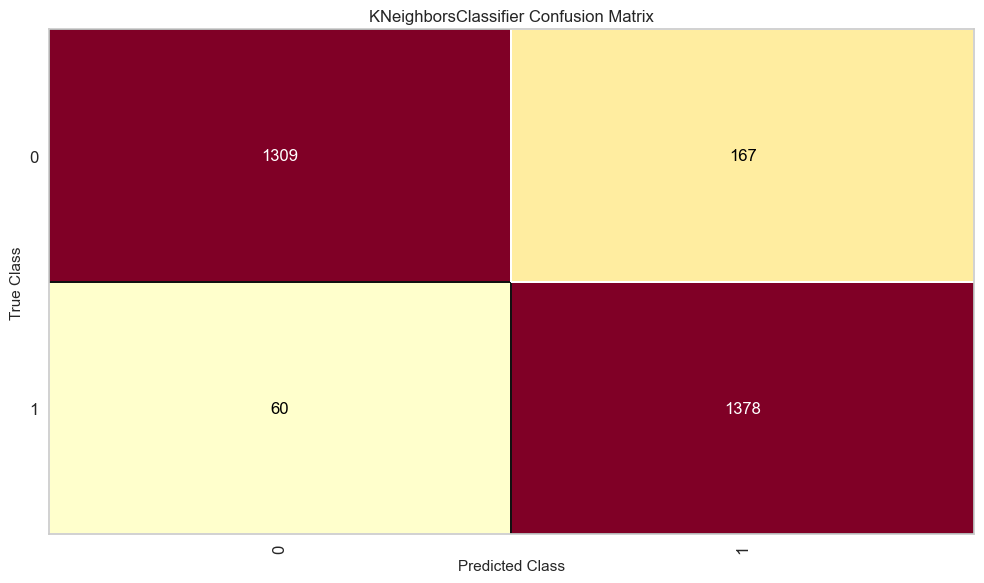

<Axes: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [81]:
plt.figure(figsize=(10, 6))
cm = ConfusionMatrix(model)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

In [82]:
distances = model.kneighbors(X_test, return_distance=True)[0]
distances

array([[0.00804939],
       [0.04634537],
       [0.00148652],
       ...,
       [0.01465681],
       [0.09983834],
       [0.02413542]])

In [83]:
distance_threshold = 0.5  
outliers_indices = np.where(distances[:, 0] > distance_threshold)[0]

print("Outliers based on KNN distances:", outliers_indices)

Outliers based on KNN distances: [  15   58  162  271  278  298  311  349  410  448  478  503  593  602
  643  757  769  907  920 1006 1026 1054 1060 1099 1201 1372 1378 1438
 1462 1550 1628 1668 1758 1849 1893 1997 2035 2098 2183 2333 2334 2374
 2438 2474 2527 2559 2709]


In [84]:
y_test = y_test.to_list()
len(y_test)

2914

In [85]:
num_of_fp = 0
for i in range(X_test.shape[0]):
    if i in outliers_indices:
        if y_pred[i] == 1 and y_test[i] == 0:
            num_of_fp += 1

num_of_fp

8

In [89]:

model = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='manhattan')

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(f'Optimal parameters: f{knn_grid_model.best_params_}')
cm = confusion_matrix(y_test, model.predict(X_test))

print("Confusion Matrix: \n", cm)
print("Model testing accuracy:", ((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))*100, "%", sep=' ')

print(f'Precision Score: {precision_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'Recall Score: {recall_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, model.predict(X_test))*100:.2f}%')
print()

Optimal parameters: f{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Confusion Matrix: 
 [[1311  165]
 [  57 1381]]
Model testing accuracy: 92.38160603980783 %
Precision Score: 89.33%
Recall Score: 96.04%
F1 Score: 92.56%



In [88]:

model = KNeighborsClassifier(n_neighbors=2, weights='uniform', metric='manhattan')

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(f'Optimal parameters: f{knn_grid_model.best_params_}')
cm = confusion_matrix(y_test, model.predict(X_test))

print("Confusion Matrix: \n", cm)
print("Model testing accuracy:", ((cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))*100, "%", sep=' ')

print(f'Precision Score: {precision_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'Recall Score: {recall_score(y_test, model.predict(X_test))*100:.2f}%')
print(f'F1 Score: {f1_score(y_test, model.predict(X_test))*100:.2f}%')
print()

Optimal parameters: f{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Confusion Matrix: 
 [[1359  117]
 [  91 1347]]
Model testing accuracy: 92.86204529855868 %
Precision Score: 92.01%
Recall Score: 93.67%
F1 Score: 92.83%



# Conclusion

* Our results with the KNN model for this dataset are not very good.
* Although we did cross validation and found the most suitable parameters with GridSearch, we could not achieve the desired improvement in our results.
* After this point let's go on with other models.